## Ridge Regression

We will use Ridge Regression to understand how far we can go using a regularized linear model. We will customize our pipeline such that initially we won't perform final dimension reduction or interaction terms. Later we will test whether adding these would significantly improve model performance. 

### Ridge Regression without interaction terms

#### Feature Extraction Pipeline

We anticipate that this would be the simplest pipeline we can start with. Basically, we will use all features after tokenization and simply rely on the regularization capacity of the Ridge Regression. 

In [6]:
# Save the work into a dedicated workspace "ridge"
disk_ridge = "ridge"
import os
if not os.path.exists(disk_ridge):
    os.makedirs(disk_ridge) 

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_Ridge1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2 ** 18,decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,1), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
   
])

# Note that we will explore feature selection strategies to determine the number of features to keep after 
# tokenization and feature union

#### Build the feature extraction pipeline using training set and transform both data sets

In [10]:
import pickle
# Load Training and Validation sets
disk = "D:\Data_science\GitHub\Predictive-Modeling-510k-decision-time"
# Validation set 
with open(disk+"\X_val.pkl","rb") as f:
    X_val=pickle.load(f)

with open(disk+"\y_val.pkl","rb") as f:
    y_val=pickle.load(f)
    
# Training set (Locked down)
with open(disk+"\X_train.pkl","rb") as f:
    X_train=pickle.load(f)

with open(disk+"\y_train.pkl","rb") as f:
    y_train=pickle.load(f)    

In [17]:
import datetime
from warnings import filterwarnings

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_ridge = pipeline510k_Ridge1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_ridge = pipeline510k_Ridge1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 0.75 minutes.
Completed processing X_val in: 0.16666666666666666 minutes.


#### Training untuned Ridge model

In [22]:
from sklearn.linear_model import Ridge
from sklearn.metrics import median_absolute_error

start = datetime.datetime.now()

ridge1 = Ridge(alpha=0.7)

ridge1.fit(X_train_trans_ridge, y_train)
preds = ridge1.predict(X_val_trans_ridge)

mae = median_absolute_error(y_val,preds)

end = datetime.datetime.now()
print("Median Absolute Error: ", str(mae))
print("Completed model fit and predictions in: " + str((end-start).seconds/60) + " minutes.")

Median Absolute Error:  53.129185291124514
Completed model fit and predictions in: 0.5833333333333334 minutes.


(-250, 1500)

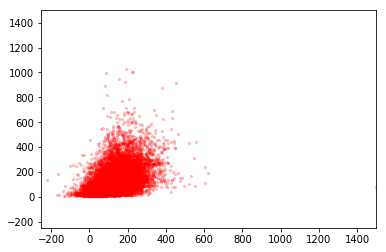

In [34]:
import matplotlib.pyplot as plt
plt.scatter(x = preds, y = y_val, alpha = 0.2, c = "red", s = 5)
plt.ylim(-250,1500)
plt.xlim(-250,1500)



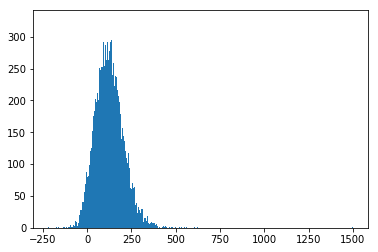

In [37]:
plt.hist(preds, bins= 500)
plt.show()

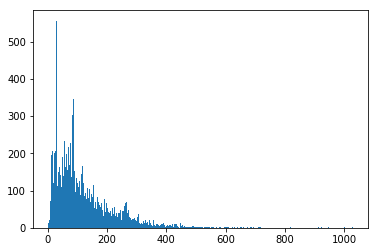

In [39]:
plt.hist(y_val, bins= 500)
plt.show()

Let's try to see the impact of transforming the target during model training.